In [1]:
from IPython.display import display, HTML
HTML(
    """
    <script
        src='https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js'>
    </script>
    <script>
        code_show=true;
        function code_toggle() {
        if (code_show){
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
        } else {
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
        }
        code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'>
        <input type="submit" value='Click here to toggle on/off the raw code.'>
    </form>
    """
)

In [2]:
import random
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords, wordnet, words
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec

import torch
import torch.nn as nn
import torch.optim as optim
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing

from tensorflow.keras import layers, Model

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.pipeline import Pipeline

from pyod.models.lunar import LUNAR

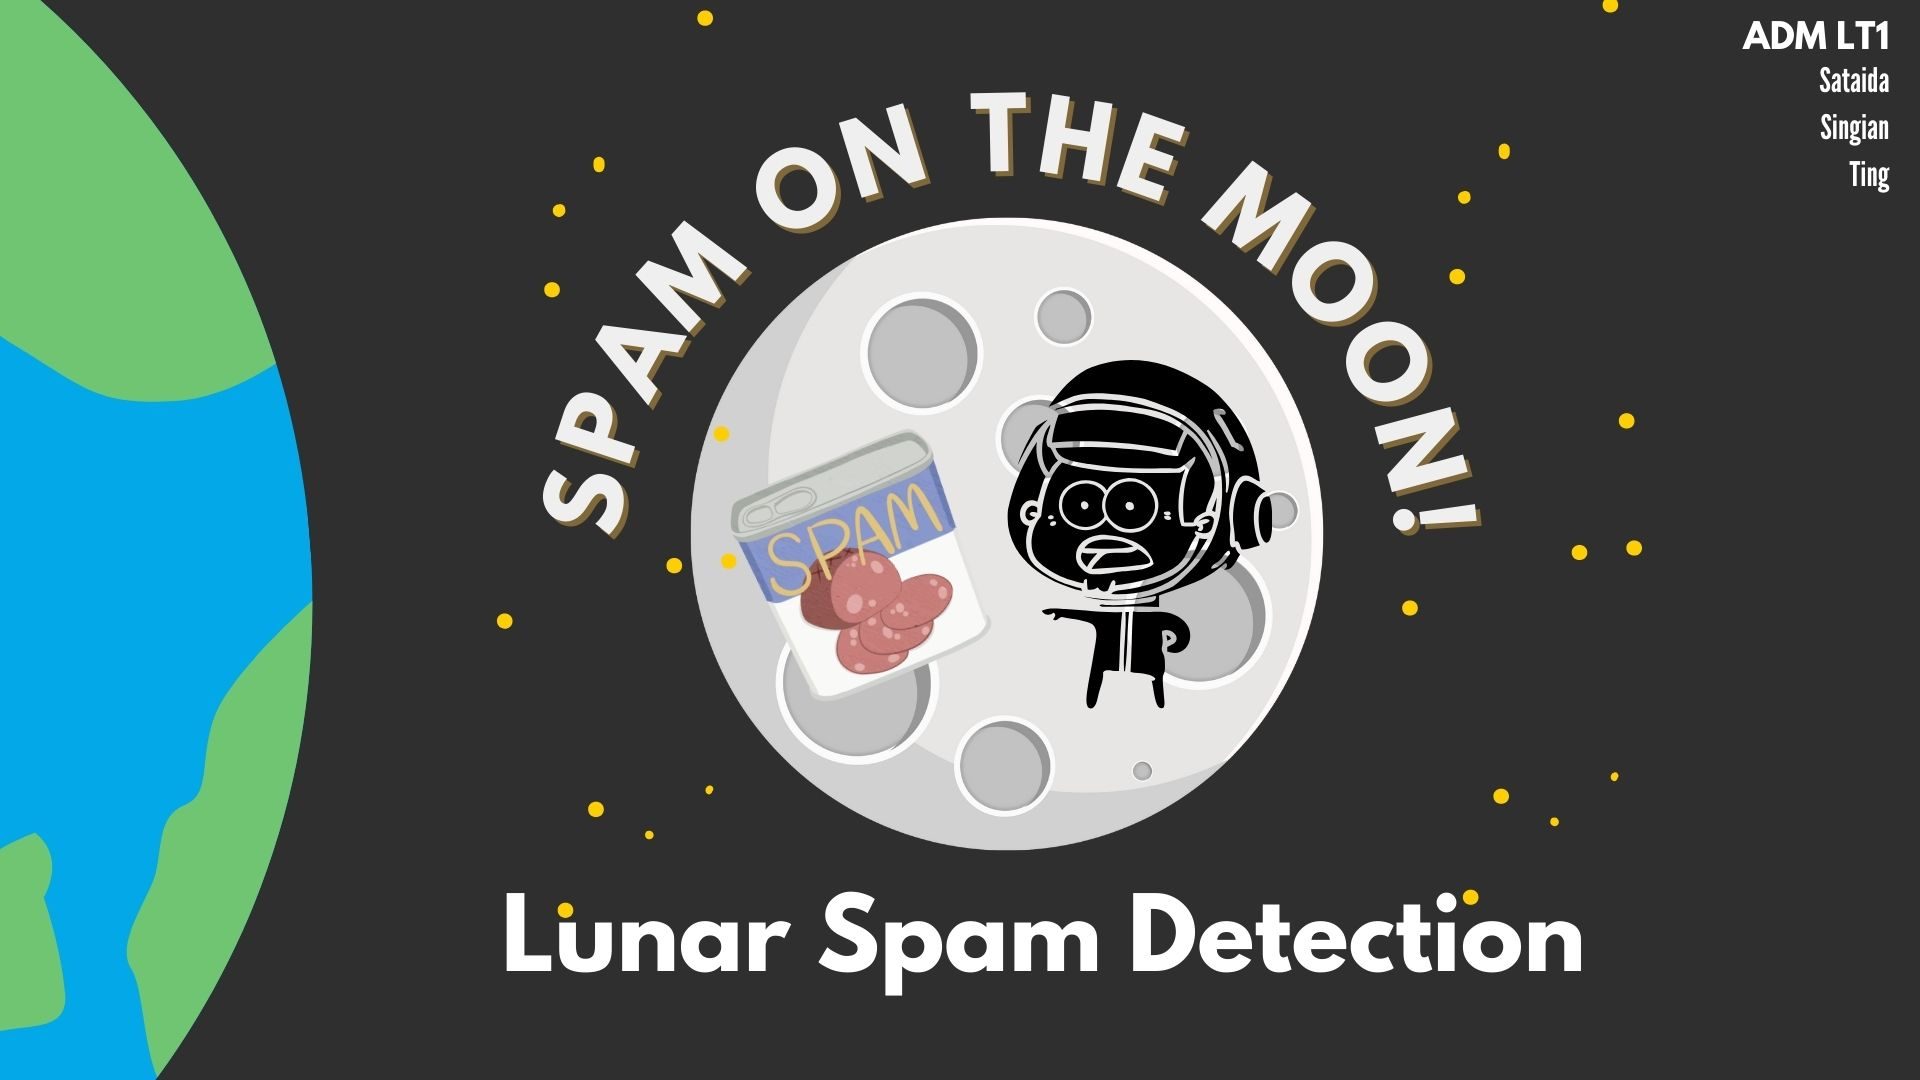

In [2]:
from IPython.display import Image
Image(filename="1.jpg")

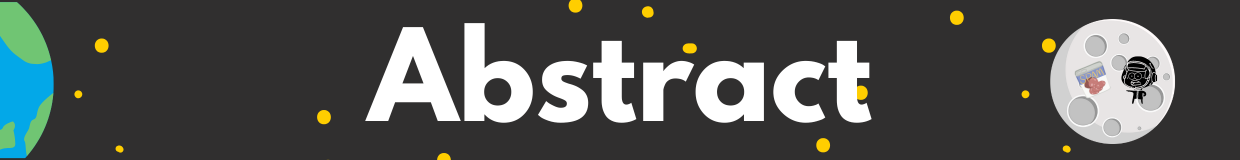

In [3]:
from IPython.display import Image
Image(filename="1.png")

This project explores the application of graph neural networks (GNNs) combined with cosine similarity for anomaly detection in spam emails. We developed a model that uses the power of GNNs in capturing relationships between emails by using cosine similarity as measures of distance between emails in a text-based feature space. The results demonstrate that our model outperforms several baseline approaches, achieving a balanced performance with high precision (95.98%) in spam detection.

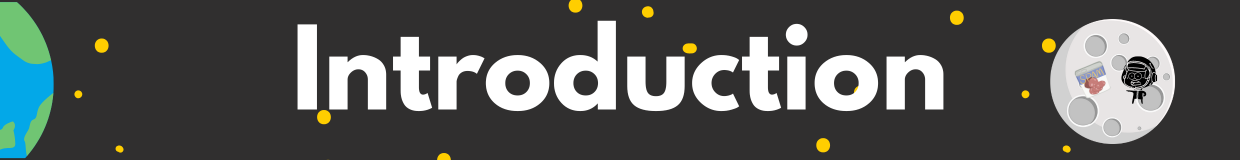

In [4]:
from IPython.display import Image
Image(filename="2.png")

The internet has become a huge part of our daily lives. We use it for all sorts of activies, like buying stuff online, booking trips, keeping up with friends on social media, and sending emails. For most websites, we need to use our email address as an identification to register on the site. Often times, these websites send us emails to keep us posted for new products, updates, and special offers or promos.

This make it hard to manage our email inboxes. There can be a lot of unwanted emails mixed with the important ones. These unwanted emails are called spam, and can be a real nuisance. We need to scroll a lot to find the emails that we actually need. Even worse, some of these spam emails can pose a threat. They might be used for phishing scams to get our personal information or clicking on the links could download viruses that leads to harming our computer.

With so much spam around, it is important to find ways to distinguish them from our real email. This project investigates the potential of applying outlier detection techniques to tackle the challenge of spam detection.

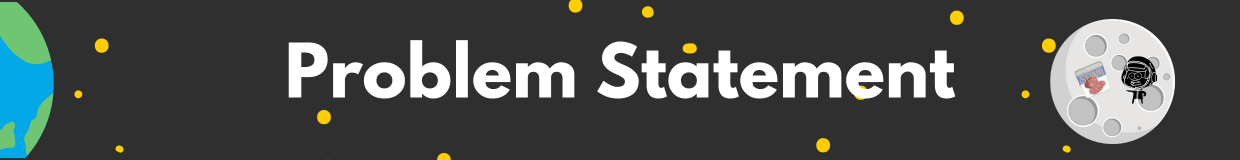

In [5]:
from IPython.display import Image
Image(filename="3.png")

Traditional spam detection methods often rely on supervised learning, which requires a significant amount of labeled data. However, the imbalanced nature of spam emails, where they represent a minority class compared to legitimate emails, poses a challenge for these approaches.

This project aims to address this challenge by exploring outlier detection techniques for spam detection.  By framing spam emails as outliers within the email data, we can potentially develop a robust and efficient method for identifying them, even in an imbalanced data environment.

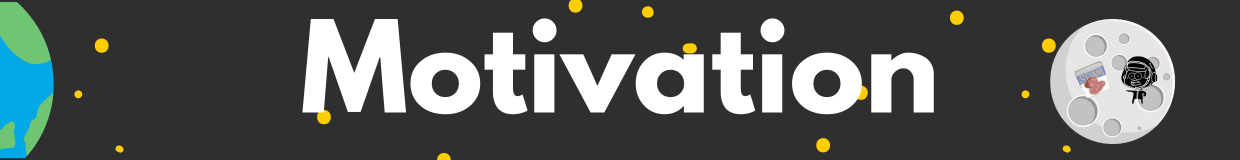

In [6]:
from IPython.display import Image
Image(filename="4.png")

Inspired on the LUNAR's effectiveness on anomaly detection, we investigated the possibility of adapting and applying this approach to the domain of text data, specifically the spam detection. Our goal is to assess whether a GNN model, combined with cosine similarity, can be effective in identifying spam emails in an imbalanced spam emails dataset.

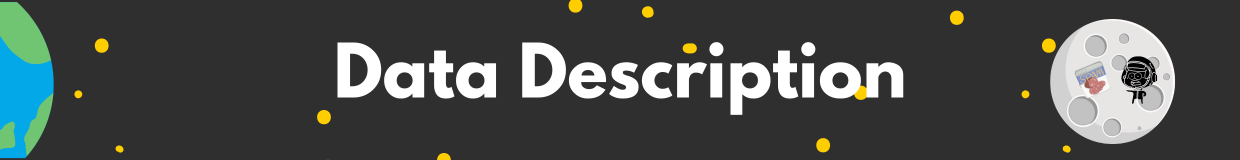

In [8]:
from IPython.display import Image
Image(filename="5.png")

The data was obtained in Kaggle (Spam email dataset, n.d.). It contains a collection of email texts messages categorized as either spam or not spam.

The dataset consists of two columns:
- text(str): This column contains the entire content of the email, including the body text, subject line, and any associated headers.
- spam(int): This column provides the binary label indicating whether an email is spam (1) or not spam (0).

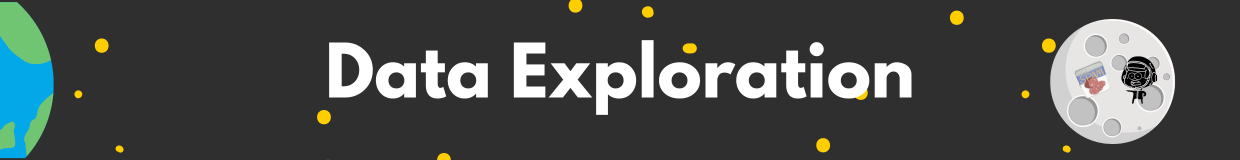

In [9]:
from IPython.display import Image
Image(filename="6.png")

First, we load the `email.csv` using into a pandas dataframe and the sample of the dataset is shown on the table below.

In [3]:
df = pd.read_csv('emails.csv')

In [4]:
df.head()

,text,spam
0,Subject: banner life upgraded to a + + effect...,1
1,"Subject: levltrra , xana , merldll hello , tr...",1
2,Subject: save your money buy getting this thin...,1
3,Subject: an alternative to mlm that works gre...,1
4,Subject: v . i . a . g . r . a - the cheappess...,1


Next, we check the basic information and statistics of the data.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4947 non-null   object
 1   spam    4947 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 77.4+ KB


- There are 2 columns, namely text and spam, 4947 entries, and no missing values.

In [6]:
df2 = df.copy()

df2['text_length'] = df2['text'].apply(len)
all_email = df2['text_length'].describe()
non_spam = df2[df2['spam'] == 0]['text_length'].describe()
spam = df2[df2['spam'] == 1]['text_length'].describe()

In [7]:
pd.DataFrame({
  'All Email': all_email,
  'Non-Spam': non_spam,
  'Spam': spam
})

,All Email,Non-Spam,Spam
count,4947.000000,4358.000000,589.000000
mean,1580.611886,1612.499771,1344.674024
std,1802.996647,1737.769180,2214.582193
min,13.000000,13.000000,61.000000
25%,535.500000,577.250000,395.000000
50%,1053.000000,1122.000000,730.000000
75%,1971.000000,2036.500000,1305.000000
max,31055.000000,31055.000000,17680.000000


- On average, the length of an email is 1581. In addition, the longest email length is 31055, while the shortest is 15.
- Non-spam emails tend to be more longer than spam emails.

Now, we will look into various distribution of the data, specifically:
- the distribution of the spam and non-spam emails,
- the most common words on all emails,
- the most common words on spam and not-spam emails


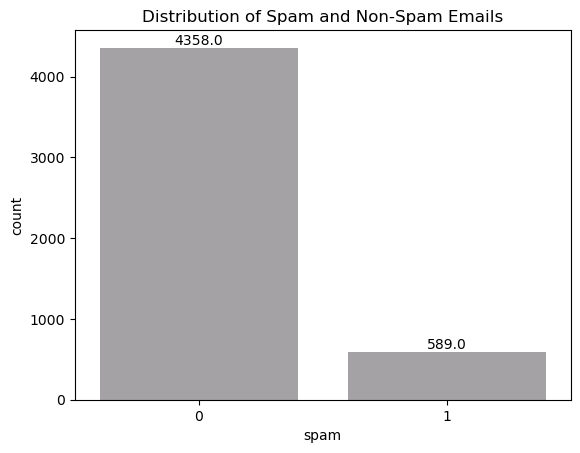

Percentage of Not Spam: 88.09%
Percentage of Spam: 11.91%


In [10]:
ax = sns.countplot(x='spam', data=df, color='#a4a2a4')
plt.title('Distribution of Spam and Non-Spam Emails')

for p in ax.patches:
    ax.annotate(f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='bottom',
                fontsize=10)

plt.show()

print(f'Percentage of Not Spam: '
      f'{df["spam"].value_counts()[0]/df.shape[0]*100:.2f}%\n'
      f'Percentage of Spam: '
      f'{df["spam"].value_counts()[1]/df.shape[0]*100:.2f}%')

- We can see from the figure above that there is a clear disproportion of the not spam and spam emails. From the total of 4947 emails, the majority of the data is non-spam email (88.09%) and the spam email is only at 11.91%.

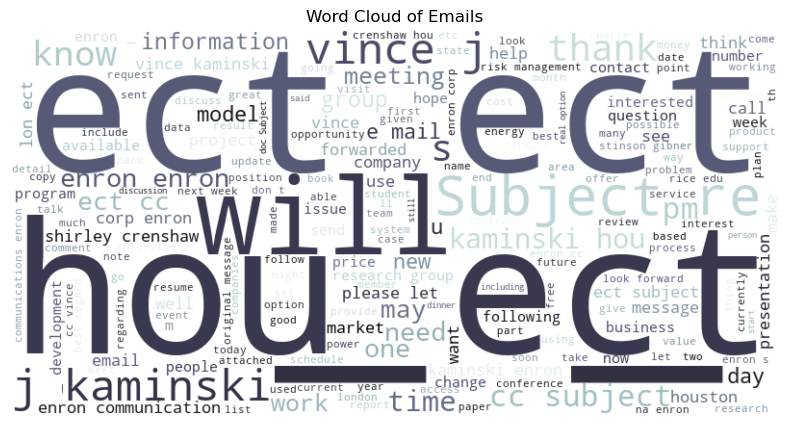

In [9]:
text_data = ' '.join(df['text'])

wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      colormap='bone').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Emails')
plt.show()

- The figure above shows a word cloud of the email contents in the dataset. Without cleaning the data, we can see that the prominent words like `hou` and `ect` might be an abbreviation. Most emails also use the words `subject` and `re` which is usual for writing organized emails.

Let's try cleaning the email contents by using stop words and considering english words as tokens.

In [12]:
# Uncomment to download
# nltk.download('stopwords')
# nltk.download('wordnet')

# Words only
def words_only(text):
    # Remove non-alphanumeric characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)
    text = text.lower()
    return text

# Filter stop words and non-English words
def filter_words(word_list):
    stop_words = set(stopwords.words('english'))
    filtered_words = [
        word for word in word_list
        if word not in stop_words and wordnet.synsets(word) and len(word) > 1
    ]
    return filtered_words

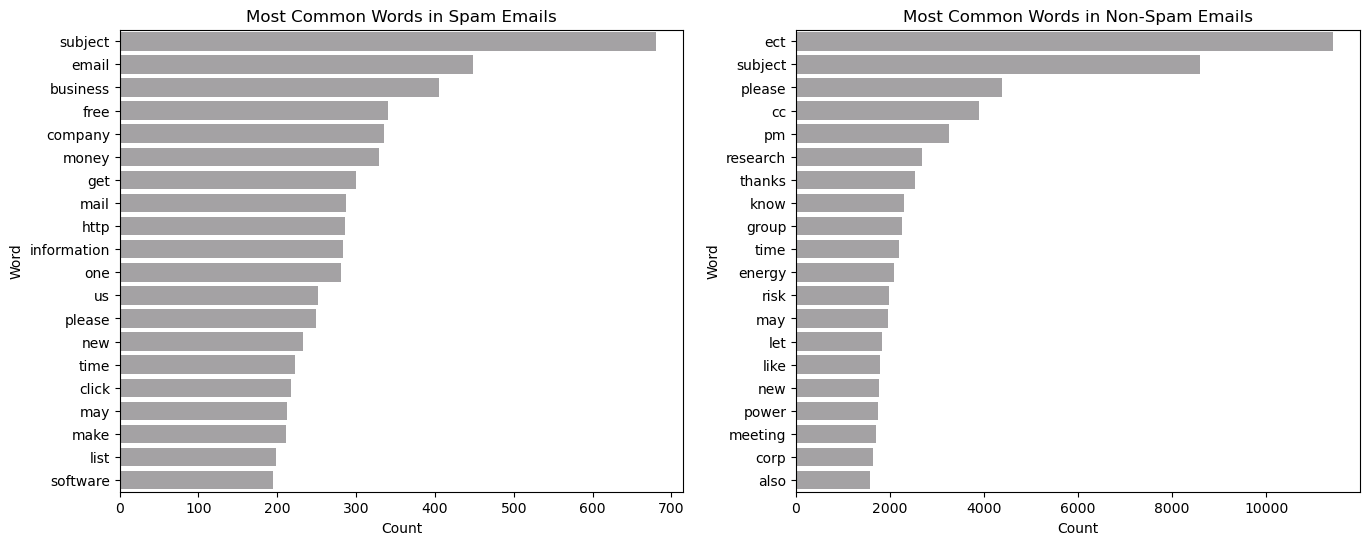

In [13]:
df2['clean_text'] = df2['text'].apply(words_only)

spam_emails = df2[df2['spam'] == 1]['clean_text']
non_spam_emails = df2[df2['spam'] == 0]['clean_text']

spam_words = ' '.join(spam_emails).split()
non_spam_words = ' '.join(non_spam_emails).split()

spam_words_filtered = filter_words(spam_words)
non_spam_words_filtered = filter_words(non_spam_words)

spam_word_count = Counter(spam_words_filtered)
non_spam_word_count = Counter(non_spam_words_filtered)

common_spam_words = pd.DataFrame(spam_word_count.most_common(20),
                                 columns=['Word', 'Count'])
common_non_spam_words = pd.DataFrame(non_spam_word_count.most_common(20),
                                     columns=['Word', 'Count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
sns.barplot(x='Count',
            y='Word',
            data=common_spam_words,
            ax=axes[0],
            color='#a4a2a4')
axes[0].set_title('Most Common Words in Spam Emails')
sns.barplot(x='Count',
            y='Word',
            data=common_non_spam_words,
            ax=axes[1],
            color='#a4a2a4')
axes[1].set_title('Most Common Words in Non-Spam Emails')
plt.show()

- The figure above shows the top 20 most common words used in the spam and non spam emails. The following are the observations for both emails, respectively:
    - Spam: We can see that there are prevalence on the words `free`, `get`, and `money`, suggesting that spam emails entice the receiver with free services or monetary gain. There is also words like `click` and `https` which could lead to potential phishing sites to get user information.
    - Non-Spam: We can see words like `please` and `thanks` which indicates polite tone and is commonly found in professional or personal emails. Also, there are words like `research`, `group`, `time`, and `meeting` which shows that there are collaboration and scheduling content in non-spam emails.

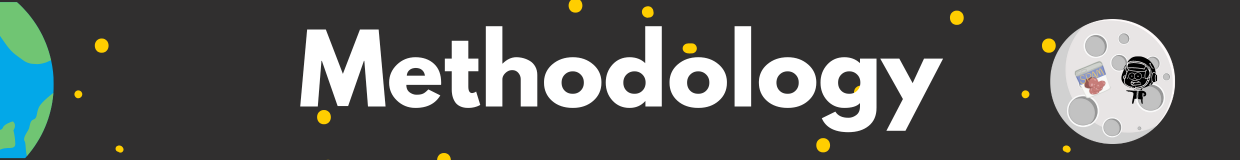

In [10]:
Image(filename="7.png")

<div style="background-color: #333334; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Overview</h1></center>
</div>

In this project, we adopted a systematic approach for analyzing the spam email dataset, following the steps outlined below:

1. **Data Retrieval**: We retrieved the data from the Kaggle website.

2. **Data Exploration**:  We began with an initial exploration of the data to understand its characteristics, including the distribution of values and any potential issues that might require addressing during preprocessing.

3. **Data Preparation**: We conducted a series of data preprocessing steps to ensure the data was suitable for analysis. This involved cleaning the data to address any identified issues. We then employed word embedding techniques, such as word2vec, to represent words numerically. Finally, we split the dataset into training, validation, and testing sets.

4. **Model Training and Evaluation**: We implemented several baseline models like Isolation Forest (IF), Local Outlier Factor (LOF), K-Nearest Neighbors (KNN), and LUNAR (a GNN-based approach). We also developed our own model leveraging GNNs and cosine similarity. We evaluated their performance on the unseen testing set using metrics like accuracy, precision, recall, F1-score, and ROC-AUC score.

<div style="background-color: #333334; padding: 10px 0;">
<center><h1 style="color: white; font-family:Arial; font-weight:bold">Detailed</h1></center>
</div>

### Data Preparation

After our initial exploration, we identified several issues that need to be addressed before using the dataset for model training. First, the entries in the text column begin with the word `Subject` followed by a colon (`:`). We will remove this introductory part of the email, retaining only the subsequent text, as it represents the expected content of an email.

In [12]:
df['text'] = df['text'].str.replace(r'^Subject: ','', regex=True).str.lower()

Next, we will further clean the text column by removing non-english words and non-alphanumeric characters.

In [13]:
def is_english_word(word):
    return word.lower() in english_words and len(word) >= 2

def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words_list = text.split()
    english_words_list = [word for word in words_list if is_english_word(word)]
    cleaned_text = ' '.join(english_words_list)
    return cleaned_text

In [14]:
# Uncomment to download
# nltk.download('words')

english_words = set(words.words())

In [15]:
df['cleaned'] = df['text'].apply(clean_text)

Since there are a total of 589 non-spam emails, we will also select an equal number of spam emails to create the test set.

In [16]:
spam = df[df['spam'] == 1].reset_index(drop=True)
ham = df[df['spam'] == 0].reset_index(drop=True)

test = pd.concat([ham.iloc[:589, :], spam])

We will allocate the remaining dataset to create the train and validation sets. To achieve this, we’ll utilize the train_test_split function, setting the test size ratio to 15%.

In [17]:
train_val = ham.iloc[589:].reset_index(drop=True)

train, val = train_test_split(train_val, test_size=0.15, random_state=42)

Before the models can use our prepared datasets, we must ensure that the data is in the appropriate format. To capture the meaning of email texts based on surrounding words, we’ll employ `word2vec` to create representations. However, before proceeding with word2vec, we need to tokenize the texts using `word_tokenize`.

In [18]:
train['tokens'] = train['cleaned'].apply(word_tokenize)
val['tokens'] = val['cleaned'].apply(word_tokenize)
test['tokens'] = test['cleaned'].apply(word_tokenize)

In [19]:
vec_size = np.floor(train['cleaned'].apply(len).mean()).astype(int)
model = Word2Vec(sentences=train['tokens'], vector_size=vec_size)

In [20]:
def vectorize_text(tokens, model):
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [21]:
train['vector'] = train['tokens'].apply(
    lambda tokens: vectorize_text(tokens, model))
val['vector'] = val['tokens'].apply(
    lambda tokens: vectorize_text(tokens, model))
test['vector'] = test['tokens'].apply(
    lambda tokens: vectorize_text(tokens, model))

In [22]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

In [23]:
train_final = pd.concat(
    [pd.DataFrame(np.stack(train['vector'].values)), train['spam']], axis=1)
val_final = pd.concat(
    [pd.DataFrame(np.stack(val['vector'].values)), val['spam']], axis=1)
test_final = pd.concat(
    [pd.DataFrame(np.stack(test['vector'].values)), test['spam']], axis=1)

Due to internal randomization of word2vec, we will save the datasets into a csv format. A sample of the train and test dataset is shown below.

In [24]:
# train_final.to_csv('train_df.csv', index=False)
# val_final.to_csv('val_df.csv', index=False)
# test_final.to_csv('test_df.csv', index=False)

In [25]:
df_train = pd.read_csv('train_df.csv')
df_val = pd.read_csv('val_df.csv')
df_test = pd.read_csv('test_df.csv')

In [26]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,898,899,900,901,902,903,904,905,906,spam
0,0.080591,0.014780,-0.012505,0.112791,0.131489,-0.130928,0.039143,-0.005090,0.009409,0.009901,...,-0.081855,0.130907,-0.093387,-0.056449,0.021544,-0.057430,0.069778,0.040280,0.031409,0
1,0.102434,-0.003797,-0.034523,0.073787,0.126353,-0.180468,0.066750,-0.032993,-0.047827,0.036269,...,-0.075111,0.111684,-0.134795,-0.087234,-0.004427,-0.022129,0.036939,0.029211,0.025835,0
2,0.086012,0.008998,0.000511,0.058476,0.124684,-0.177186,0.060226,-0.014635,-0.026348,-0.007854,...,-0.101672,0.047570,-0.125398,-0.058119,0.034180,-0.036140,0.010393,0.069395,0.097736,0
3,0.122765,-0.066234,0.028842,0.051126,0.114775,-0.096505,0.012152,-0.024743,-0.065966,0.041883,...,-0.091154,0.113762,-0.066670,-0.101444,0.060948,-0.020019,-0.017859,0.075869,0.034348,0
4,0.086969,0.005782,0.001740,0.122761,0.161254,-0.160150,0.068508,-0.011297,-0.018395,0.025918,...,-0.114359,0.135247,-0.098894,-0.064444,0.014806,-0.057716,0.091365,0.047732,0.048035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,0.153612,-0.085317,0.029641,0.153924,0.159473,-0.183323,0.077997,-0.020273,-0.059795,0.032154,...,-0.046808,0.109653,-0.133395,-0.106046,0.018044,-0.033564,0.088129,0.001045,0.040474,0
3199,0.143752,-0.106318,0.078686,0.031079,0.097815,-0.151020,0.063758,-0.029014,-0.097920,0.054978,...,0.004422,0.077651,-0.065532,-0.096877,0.014632,-0.005457,0.076676,0.009147,-0.026272,0
3200,0.236657,-0.152296,0.102628,0.151604,0.215401,-0.209027,0.079949,-0.050547,-0.103424,0.107368,...,-0.146426,0.239524,-0.063199,-0.086230,-0.032211,-0.025009,0.061257,0.079615,0.052989,0
3201,0.140277,-0.105642,0.092046,0.070749,0.097295,-0.127376,0.047172,-0.058487,-0.097069,0.048664,...,-0.002261,0.101943,-0.053873,-0.124535,0.009002,-0.010736,0.104443,0.016661,-0.032265,0


In [27]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,898,899,900,901,902,903,904,905,906,spam
0,0.140580,-0.084375,-0.006334,0.046640,0.142991,-0.162758,0.037999,-0.073778,-0.096714,0.028629,...,-0.075134,0.081817,-0.125869,-0.135761,0.054720,0.007746,-0.014615,0.046623,0.027387,0
1,0.096687,-0.045270,0.011296,0.106449,0.115923,-0.156600,0.051163,-0.016710,-0.046107,0.004577,...,-0.073708,0.077857,-0.117222,-0.107723,0.033367,-0.025623,0.071159,0.017492,0.043829,0
2,0.115732,-0.043216,0.056517,0.108590,0.110782,-0.144786,0.048886,-0.037513,-0.042715,0.037891,...,-0.012366,0.106810,-0.069297,-0.061881,0.003567,-0.017652,0.130188,0.012084,-0.040372,0
3,0.132200,-0.076337,0.038824,0.074127,0.121205,-0.186307,0.087874,-0.012159,-0.091456,0.026076,...,-0.037577,0.053682,-0.105626,-0.137550,0.038730,-0.030929,0.056197,0.002853,0.038174,0
4,0.105137,-0.045997,-0.008313,0.090232,0.157028,-0.159866,0.057221,-0.016919,-0.040745,0.000009,...,-0.127701,0.096665,-0.095012,-0.112825,0.049159,-0.037723,0.011452,0.054218,0.081831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,0.047001,0.013408,0.016856,0.136534,0.182664,-0.138852,0.060548,-0.012081,0.018819,-0.012838,...,-0.117055,0.152242,-0.089714,-0.080839,0.037226,-0.027807,0.095074,0.024228,0.054112,1
1174,0.056712,-0.007632,-0.008258,0.098918,0.179046,-0.186819,0.095695,-0.006174,-0.017717,-0.045306,...,-0.107805,0.083704,-0.180995,-0.151102,0.053676,-0.062422,0.071577,0.032193,0.110981,1
1175,0.118153,-0.067139,0.050476,0.088462,0.128821,-0.171668,0.043130,-0.043947,-0.067672,0.014517,...,-0.039432,0.092408,-0.106319,-0.072412,0.013984,-0.010812,0.101393,0.012389,0.011983,1
1176,0.068643,-0.037450,0.026953,0.104699,0.167271,-0.149322,0.042340,-0.021611,-0.022831,-0.043766,...,-0.139989,0.132839,-0.109300,-0.073842,0.056447,-0.051280,0.086461,0.050746,0.125296,1


Now our dataset is ready to be used for model training.

### Model Training and Evaluation

We will investigate several baseline models commonly used for anomaly detection, including `Isolation Forest`, `Local Outlier Factor`, and `KNN`. Additionally, we’ll employ `LUNAR`, a graph neural network-based anomaly detection algorithm. These models will serve as benchmarks against our own model, which we’ll discuss in more detail later.

All models are evaluated using `accuracy`, `precision`, `recall`, and `F1` metrics. In addition, all GNN-based models are scored using `ROC_AUC`.

#### Isolation Forest

Isolation forest (IF) is an unsupervised anomaly detection model that isolates outliers by partitioning the data points randomly.

We implemented the IF model using `sklearn.ensemble.IsolationForest` on default parameters. Then `fit_predict` was used to simultaneously train and predict anomaly scores for the datapoints. However, since IF is an unsupervised model, we removed the labels on the test set. Next, the anomaly scores are converted for evaluation. Finally, the model is evaluated using the previously mentioned metrics, as shown below.

In [29]:
df_test = df_test.sample(frac = 1).reset_index(drop=True)

df_test1 = df_test.iloc[:, :-1]
df_test_label = df_test['spam']

In [30]:
from sklearn.ensemble import IsolationForest

model_if = IsolationForest()

y_pred_if = model_if.fit_predict(df_test1)
y_pred_ss = model_if.score_samples(df_test1)

y_pred_if[y_pred_if == -1] = 2
y_pred_if[y_pred_if == 1] = 0
y_pred_if[y_pred_if == 2] = 1

print(f"accuracy: {accuracy_score(df_test_label, y_pred_if):.4}")
print(f"precision: {precision_score(df_test_label, y_pred_if):.4}")
print(f"recall: {recall_score(df_test_label, y_pred_if):.4}")
print(f"f1: {f1_score(df_test_label, y_pred_if):.4}")

accuracy: 0.4601
precision: 0.2577
recall: 0.04244
f1: 0.07289


#### Local Outlier Factor

Local Outlier Factor (LOF) is a density-based anomaly detection method that uses densities of the data point and compare it to its neighbor. Anomalies are determined by how less dense it is compared to other data points.

From the scikit-learn library, we used `LocalOutlierFactor` to implement LOF with default parameters. Similar to IF, we used `fit_predict` to get the anomaly scores. The results of the evaluation is shown below.

In [31]:
model_lof = LocalOutlierFactor()

y_pred_lof = model_lof.fit_predict(df_test1)

y_pred_lof[y_pred_lof == -1] = 2
y_pred_lof[y_pred_lof == 1] = 0
y_pred_lof[y_pred_lof == 2] = 1

print(f"accuracy: {accuracy_score(df_test_label, y_pred_lof):.4}")
print(f"precision: {precision_score(df_test_label, y_pred_lof):.4}")
print(f"recall: {recall_score(df_test_label, y_pred_lof):.4}")
print(f"f1: {f1_score(df_test_label, y_pred_lof):.4}")

accuracy: 0.4737
precision: 0.3652
recall: 0.07131
f1: 0.1193


#### K-Nearest Neighbors

K-nearest neighbors (KNN) is a supervised learning model that uses distance between a data point to its nearest K-neighbors to identify anomalies. Points with larger distance are considered outliers. In a typical supervised learning, KNN uses labeled data to classify data points.

However, to maintain the consistency with the methodology used in graph neural network (GNN) based models, particularly LUNAR, we adapted its approach for training the model. LUNAR model assumes data is already "normal" and to make it a supervised learning, it employs negative sampling. Negative sampling involves generating synthetic negative instances as anomalies to use it for training.

In [32]:
def generate_negative_samples_u(x, epsilon=0.1):
    n_samples = len(x) 
    n_dim = x.shape[1]

    # Generate uniform negative samples
    neg_x = epsilon * (1 - 2 * np.random.rand(n_samples, n_dim))
    neg_y = np.ones(len(neg_x)) 

    return neg_x.astype('float32'), neg_y.astype(int)

def generate_negative_samples_sp(x, epsilon=0.1, perturbation_factor=0.1):
    n_samples = len(x) 
    n_dim = x.shape[1]

    # Initialize negative samples as a copy of the original data
    neg_x = np.copy(x)
    
    # Perturb a subspace of the dimensions
    n_subspace_dim = int(perturbation_factor * n_dim)  # Define the size of the subspace
    subspace_indices = np.random.choice(n_dim, n_subspace_dim, replace=False)  # Randomly select subspace dimensions

    # Add small perturbations to the subspace dimensions
    for i in subspace_indices:
        perturbations = epsilon * (2 * np.random.rand(n_samples) - 1)  # Perturbations in the range [-epsilon, epsilon]
        neg_x[:, i] += perturbations

    neg_y = np.ones(len(neg_x))  # Labels for negative samples

    return neg_x.astype('float32'), neg_y.astype(int)

In [33]:
train_x = df_train.iloc[:, :-1].values
neg_train_x, neg_train_y = generate_negative_samples_u(train_x)

val_x = df_val.iloc[:, :-1].values
neg_val_x, neg_val_y = generate_negative_samples_u(val_x)

In [34]:
def get_concat(x, y, df):
    df_neg = pd.DataFrame(x, columns=df.columns[:-1])
    neg_label = pd.DataFrame(y, columns=[df.columns[-1]])
    df_spam = pd.concat([df_neg, neg_label.astype(int)], axis=1)

    return pd.concat([df, df_spam], ignore_index=True)

In [35]:
df_train_ns = (get_concat(neg_train_x, neg_train_y, df_train)
               .sample(frac = 1).reset_index(drop=True))
df_val_ns = (get_concat(neg_val_x, neg_val_y, df_val)
             .sample(frac = 1).reset_index(drop=True))

In [36]:
df = pd.concat([df_train_ns, df_val_ns], ignore_index=True)
df_ns = df.iloc[:, :-1]
df_ns_label = df['spam']

To implement the KNN model, we used grid search and cross validation for optimization. We defined the range of neighborhood sizes from 1 to 50 and a cross validation of 5.

In [37]:
n_neighbor_range = list(range(1, 50, 1))

steps = [('scaler', None), ('clf', None)]
pipe = Pipeline(steps)
param_grid = [
    {'clf': [KNeighborsClassifier()], 'clf__n_neighbors': n_neighbor_range},
]

cv = 5
scoring = 'accuracy'
grid_search = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv,
                           verbose=2, n_jobs=-1, scoring=scoring)

grid_search.fit(df_ns, df_ns_label)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('scaler', None), ('clf', None)]),
             n_jobs=-1,
             param_grid=[{'clf': [KNeighborsClassifier()],
                          'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [38]:
print(f"The best model is: {grid_search.best_params_}")
print(f"with an acc score of: {grid_search.best_score_}")

The best model is: {'clf': KNeighborsClassifier(), 'clf__n_neighbors': 11}
with an acc score of: 0.9997346600039778


Next, we evaluate the best model and the results is shown below.

In [39]:
knn = grid_search.best_estimator_
y_pred_knn = knn.predict(df_test1)

print(f"accuracy: {accuracy_score(df_test_label, y_pred_knn):.4}")
print(f"precision: {precision_score(df_test_label, y_pred_knn):.4}")
print(f"recall: {recall_score(df_test_label, y_pred_knn):.4}")
print(f"f1: {f1_score(df_test_label, y_pred_knn):.4}")

accuracy: 0.5017
precision: 1.0
recall: 0.003396
f1: 0.006768


#### LUNAR

In our exploration of anomaly detection techniques, we also considered LUNAR, a novel method that uses GNN for identifying anomalies. LUNAR unifies local outlier methods within the message-passing framework that is commonly used in GNNs (Goodge et al., 2021).

We implemented, the LUNAR model using the `PyOD` library. The model was configured to output anomaly scores and  generate negative sampling uniformly. We allocated 15% of the data as validation set and train the model for 100 epochs.

In [42]:
model = LUNAR(model_type='SCORE', negative_sampling='UNIFORM', n_epochs=100,
              val_size=0.15)

model.fit(df_nl)

LUNAR(contamination=0.1, epsilon=0.1, lr=0.001, model_type='SCORE',
   n_epochs=100, n_neighbours=5, negative_sampling='UNIFORM',
   proportion=1.0, scaler=MinMaxScaler(), val_size=0.15, verbose=0, wd=0.1)

In [73]:
y_pred_df = model.decision_function(df_test1)
y_pred = model.predict(df_test1)

In [93]:
print(f"accuracy: {accuracy_score(df_test_label, y_pred):.4}")
print(f"precision: {precision_score(df_test_label, y_pred):.4}")
print(f"recall: {recall_score(df_test_label, y_pred):.4}")
print(f"f1: {f1_score(df_test_label, y_pred):.4}")
print(f"roc_auc: {roc_auc_score(df_test_label, y_pred_df):.4}")

accuracy: 0.4958
precision: 0.1429
recall: 0.001698
f1: 0.003356
roc_auc: 0.5343


#### Our Model

Building on the strenghts of LUNAR, we develop an anomaly detection model more tailored for spam detection problems. Our model shares the same core as the LUNAR model, which is using GNNs. However, we introduced some modifications to enhance its effectiveness to textual data:
- **Cosine Similarity for Neighborhood Comparison**: Traditional local outlier methods uses distance as measurement for similarity of data points. However, for textual data, cosine similarity offers more robustness since it captures the semantic similarity of the emails by considering the angle between their corresponding word embeddings. 
- **Tanh Activation Function in Output**: While sigmoid is often used in binary classification, the tanh function offers a wider range of output values (-1 to 1). Intuitively, our model can distinguish the separation of normal data points and anomalies more properly.

In [47]:
df_train_label = df_train_ns['spam']
df_train1 = df_train_ns.iloc[:, :-1]

df_val_label = df_val_ns['spam']
df_val1 = df_val_ns.iloc[:, :-1]

In [48]:
train_sim = (pd.DataFrame(cosine_similarity(df_train1),
                          index=df_train1.index, columns=df_train1.index))
val_sim = (pd.DataFrame(cosine_similarity(df_val1),
                        index=df_val1.index, columns=df_val1.index))

In [49]:
def get_graph(df, df_label, df2, k):
    num_nodes = df.shape[0]
    k = k
    
    edge_index = []
    edge_weight = []
    
    for i in range(df.shape[0]):
        similar_nodes = df.iloc[i].nlargest(k + 1).index[1:]
        for j in similar_nodes:
            edge_index.append([i, j])
            edge_weight.append(df.iloc[i, j])
    
    # Convert to torch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)
    
    label_tensor = torch.tensor(df_label.values, dtype=torch.float)
    return (Data(x=torch.tensor(df2.values, dtype=torch.float),
                 edge_index=edge_index, edge_attr=edge_weight,
                 num_nodes=num_nodes, y=label_tensor))

In [50]:
train_data = get_graph(train_sim, df_train_label, df_train1, 5)
val_data = get_graph(val_sim, df_val_label, df_val1, 5)

Our modelThe architecture of our model consist of four hidden layers, each using the tanh activation functions. We implemented the model using the `PyTorch` module for efficiency. The model was configured with 5 nearest neighbor. It is also trained for 100 epochs and 0.001 learning rate. We prevent overfitting by using weight decay of 0.1 and optmized using Adam optimizer with Mean Squared Error loss function.

In [51]:
class GNN1(MessagePassing):

    def __init__(self, k):
        super(GNN1, self).__init__(flow="target_to_source")
        self.k = k
        self.hidden_size = 256
        self.network = nn.Sequential(
            nn.Linear(k, self.hidden_size), nn.Tanh(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.Tanh(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.Tanh(),
            nn.Linear(self.hidden_size, 1), nn.Tanh())

    def forward(self, x, edge_index, edge_attr):
        self.network = self.network.to(dtype=torch.float32)
        out = self.propagate(edge_index=edge_index,
                             x=x,
                             edge_attr=edge_attr,
                             k=self.k,
                             network=self.network)
        return out

    def message(self, x_i, x_j, edge_attr):
        # message is the edge weight
        return edge_attr

    def aggregate(self, inputs, index, k, network):
        # concatenate all k messages
        self.input_aggr = inputs.reshape(-1, k)
        # pass through network
        out = self.network(self.input_aggr)
        return out


# GNN


class GNN(torch.nn.Module):

    def __init__(self, k):
        super(GNN, self).__init__()
        self.k = k
        self.L1 = GNN1(self.k)

    def forward(self, data):
        self.edge_attr = data.edge_attr
        self.edge_index = data.edge_index
        self.x = data.x
        out = self.L1(self.x, self.edge_index, self.edge_attr)
        out = torch.squeeze(out, 1)
        return out

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = train_data.to(device)
val_data = val_data.to(device)

In [53]:
k = 5
n_epochs = 100
lr = 0.001
wd = 0.1

model = GNN(k).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [54]:
# Define a function to evaluate the model on validation data
def evaluate(model, val_data, criterion):
    model.eval()
    with torch.no_grad():
        out = model(val_data)
        loss = criterion(out, val_data.y)
    return loss.item()
    
# Training loop
for epoch in range(n_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    train_loss = criterion(out, train_data.y)
    train_loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        val_loss = evaluate(model, val_data, criterion)
        print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: '
              f'{train_loss.item():.4f}, Val Loss: {val_loss:.4f}')

Epoch [10/100], Train Loss: 0.0164, Val Loss: 0.0255
Epoch [20/100], Train Loss: 0.0176, Val Loss: 0.0231
Epoch [30/100], Train Loss: 0.0284, Val Loss: 0.0292
Epoch [40/100], Train Loss: 0.0202, Val Loss: 0.0199
Epoch [50/100], Train Loss: 0.0173, Val Loss: 0.0174
Epoch [60/100], Train Loss: 0.0183, Val Loss: 0.0181
Epoch [70/100], Train Loss: 0.0166, Val Loss: 0.0166
Epoch [80/100], Train Loss: 0.0163, Val Loss: 0.0165
Epoch [90/100], Train Loss: 0.0165, Val Loss: 0.0165
Epoch [100/100], Train Loss: 0.0163, Val Loss: 0.0165


Finally, we can evaluate our model and the results are shown below.

In [55]:
df_test = df_test.sample(frac = 1).reset_index(drop=True)

df_test1 = df_test.iloc[:, :-1]
df_test_label = df_test['spam']

test_sim = (pd.DataFrame(cosine_similarity(df_test1),
                          index=df_test1.index, columns=df_test1.index))

test_data = get_graph(test_sim, df_test_label, df_test1, 5)
del test_data.y

test_data = test_data.to(device)

In [56]:
def predict(model, test_data):
    model.eval()
    with torch.no_grad():
        out = model(test_data)
    return out

In [58]:
test_pred = predict(model, test_data)
pred = (test_pred <= 0).float()

In [96]:
print(f"accuracy: {accuracy_score(df_test_label, pred):.4}")
print(f"precision: {precision_score(df_test_label, pred):.4}")
print(f"recall: {recall_score(df_test_label, pred):.4}")
print(f"f1: {f1_score(df_test_label, pred):.4}")
print(f"roc_auc: {roc_auc_score(df_test_label, test_pred):.4}")

accuracy: 0.6358
precision: 0.9598
recall: 0.2835
f1: 0.4377
roc_auc: 0.3024


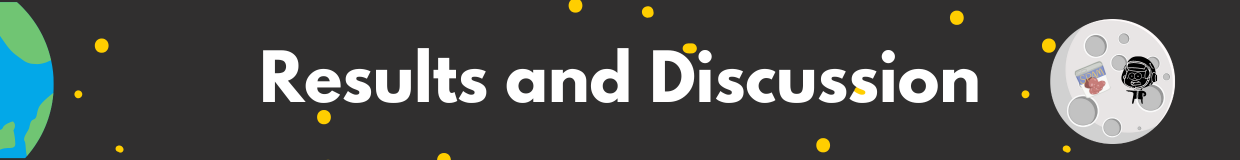

In [11]:
Image(filename="8.png")

The performance of our model and the baselines are summarized on the table below.

| Model     | Accuracy | Precision | Recall | F1     |roc_auc|
|-----------|----------|-----------|--------|--------|-------|
| Our Model | 63.58%   | 95.98%    | 28.35% | 3.777% |30.24% |
| LUNAR     | 49.58%   | 14.29%    | 0.17%  | 0.34%  |53.43% |
| IF        | 46.01%   | 24.73%    | 3.905% | 6.745% |       |
| LOF       | 47.37%   | 36.52%    | 7.131% | 1.193% |       |
| KNN       | 50.17%   | 100%      | 0.3396%| 0.6768%|       |


The results demonstrate that our model outperforms the baseline methods on most of the metrics. Our model achieved a balanced performance with an accuracy of 63.58%, precision of 95.98%, and F1-score of 3.777%. While it exhibited high precision (correctly identifying spam emails), the recall (detecting all spam emails) was lower at 28.35%. This suggests that our model can be improved further to focus on capturing true positives.

LUNAR obtained a higher ROC-AUC score (54.43%) compared to our model. This means that LUNAR is better in identfying between spam and normal emails. But, its precision and recall is considerably lower than our model. Both IF and LOF underperformed in all metrics compared to our model. Notably, KNN has a perfect precision (100%) and extremely low recall (0.34%). This suggests that it is overfitted during the training and missed almost all the actual spam emails.

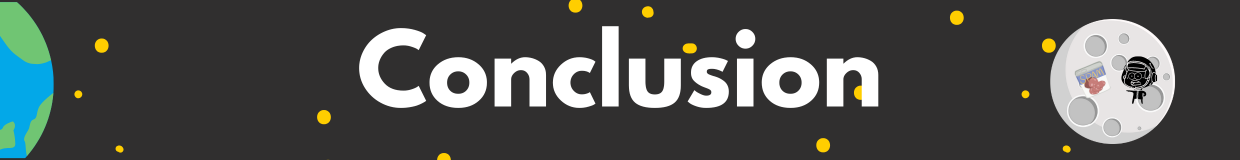

In [12]:
Image(filename="9.png")

Our project demonstrates the potential of combining graph neural networks and cosine similarity for anomaly detection in spam emails. Our proposed model achieved a balanced performance with an accuracy of 63.58% and a high precision of 95.98%, outperforming traditional methods like Isolation Forest and Local Outlier Factor. Compared to another GNN-based approach (LUNAR), our model showed significant improvement in accuracy (+14%) and precision (+81.69%)

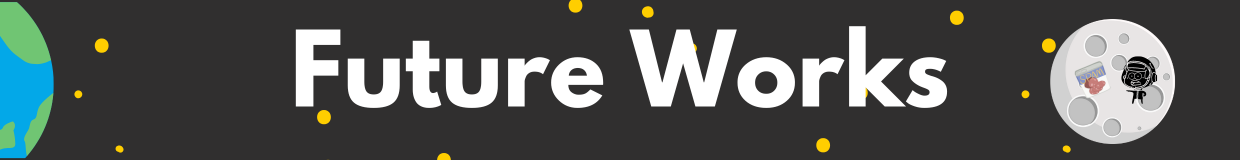

In [13]:
Image(filename="10.png")

Several areas can be improved or explored to enhance the performance and robustness of our model:

1. Model Fine Tuning
    - GNN parameters can be optimized to enable the model to capture the nuances of the email dataset. This involves experimenting on different architectures, learning rate, and regularization. Additionally, incorporating different similarity measures beyond cosine similarity might be useful to detect anomalies more effectively.


2. Data Augmentation
    - If possible, including email metadata (such as timestamp and presence of attachments) as features could potentially improve the ability to distinguish normal and spam emails.

3. Ensemble Methods
    - Exploring ensemble methods that combines multiple anomaly detection techniques could potentially increase robustness.

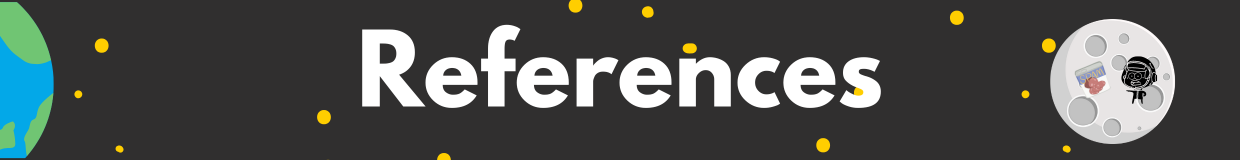

In [14]:
Image(filename="11.png")

- Spam email dataset (n.d.). Spam email Dataset. Retrieved May 24, 2024, from https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset/data
- Goodge, A., Hooi, B., Ng, S. K., & Ng, W. S. (2021, December 10). LUNAR: Unifying local outlier detection methods via graph neural networks [arXiv preprint arXiv:2112.05355]. https://arxiv.org/abs/2112.05355